Setup paths

In [16]:
import sys, os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve
)

from models_supervised import train_logreg, train_rf

# --- Paths ---
PROC_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")
TABLE_DIR = Path("../reports/tables")
MODEL_DIR.mkdir(exist_ok=True, parents=True)
TABLE_DIR.mkdir(exist_ok=True, parents=True)


Load processed dataset

In [19]:
df = pd.read_csv(PROC_DIR / "creditcard_processed.csv.gz")

Features and labels

In [20]:
X = df.drop(columns=["Class"])
y = df["Class"]

Train/validation split

In [21]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Train Logistic Regression

In [ ]:
log_cfg = {"C": 1.0, "penalty": "l2"}
log_model, log_metrics = train_logreg(
    X_tr, y_tr, X_val, y_val,
    log_cfg,
    
    
)

Train Random Forest

In [23]:
rf_cfg = {"n_estimators": 300, "max_depth": None}
rf_model, rf_metrics = train_rf(
    X_tr, y_tr, X_val, y_val,
    rf_cfg,
    save_path=MODEL_DIR / "rf.pkl"
)

Collect metrics

In [24]:
def extract_confusion_values(cm):
    """Convert confusion matrix [[TN, FP], [FN, TP]] to dictionary."""
    tn, fp, fn, tp = cm.ravel()
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}

log_cm = confusion_matrix(y_val, (log_model.predict_proba(X_val)[:,1] >= 0.5).astype(int))
rf_cm = confusion_matrix(y_val, (rf_model.predict_proba(X_val)[:,1] >= 0.5).astype(int))

log_results = {
    "model": "Logistic Regression",
    "roc_auc": log_metrics["roc_auc"],
    "pr_auc": log_metrics["pr_auc"],
    "precision": log_metrics["precision"],
    "recall": log_metrics["recall"],
    "f1": log_metrics["f1"],
    **extract_confusion_values(log_cm)
}

rf_results = {
    "model": "Random Forest",
    "roc_auc": rf_metrics["roc_auc"],
    "pr_auc": rf_metrics["pr_auc"],
    "precision": rf_metrics["precision"],
    "recall": rf_metrics["recall"],
    "f1": rf_metrics["f1"],
    **extract_confusion_values(rf_cm)
}

results = pd.DataFrame([log_results, rf_results])

# Save to CSV
results.to_csv(TABLE_DIR / "supervised_results.csv", index=False)
results

,model,roc_auc,pr_auc,precision,recall,f1,tn,fp,fn,tp
0,Logistic Regression,0.968286,0.679859,0.055407,0.873684,0.104206,55236,1415,12,83
1,Random Forest,0.949374,0.819129,0.956522,0.694737,0.804878,56648,3,29,66


Confusion Matrix & ROC/PR Curves

Logistic Regression Confusion Matrix:


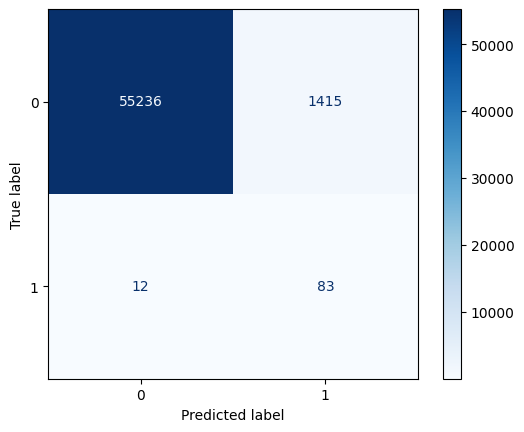

Random Forest Confusion Matrix:


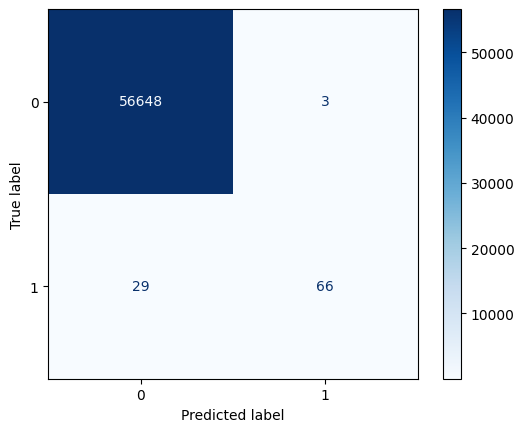

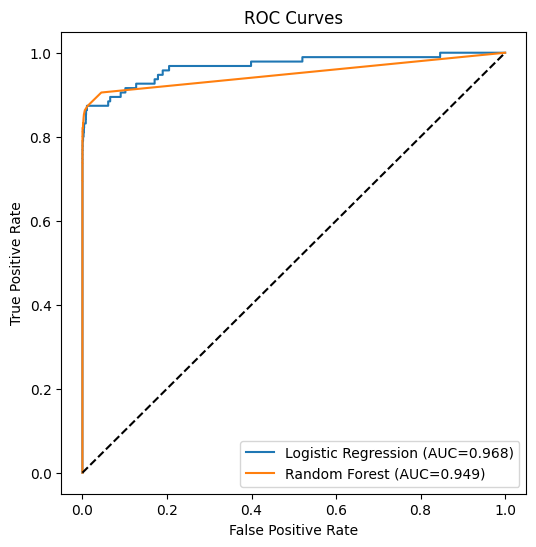

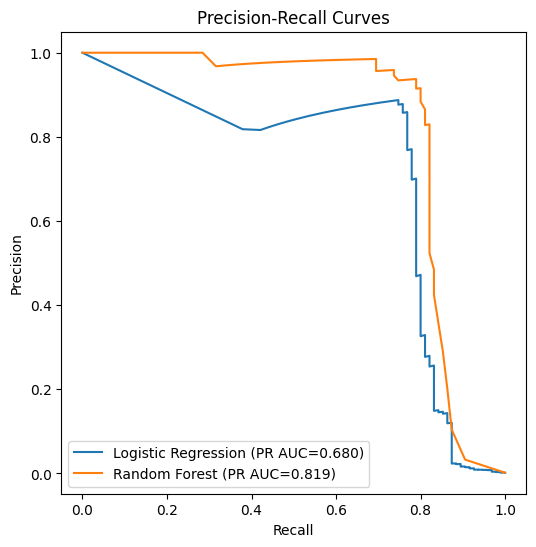

In [25]:
print("Logistic Regression Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(log_model, X_val, y_val, cmap="Blues")
plt.show()

print("Random Forest Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(rf_model, X_val, y_val, cmap="Blues")
plt.show()

# --- ROC & Precision-Recall Curves ---
def plot_roc_curve(models, X_val, y_val):
    plt.figure(figsize=(6,6))
    for label, model in models.items():
        y_score = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_score)
        auc = roc_auc_score(y_val, y_score)
        plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

def plot_pr_curve(models, X_val, y_val):
    plt.figure(figsize=(6,6))
    for label, model in models.items():
        y_score = model.predict_proba(X_val)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_score)
        pr_auc = average_precision_score(y_val, y_score)
        plt.plot(recall, precision, label=f"{label} (PR AUC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend()
    plt.show()

# Plot both curves
models_dict = {"Logistic Regression": log_model, "Random Forest": rf_model}
plot_roc_curve(models_dict, X_val, y_val)
plot_pr_curve(models_dict, X_val, y_val)